# LSTM - Long Short Term Memory Networks + GloVe

In [1]:
import tensorflow as tf
print(tf.__version__)

2.16.1


In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
import seaborn as sns

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, Flatten, Dropout, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    confusion_matrix,
    classification_report
)

## Cargar los datos y dividirlos en training y validation
Se cargan los datos preprocesados y se dividen en dos conjuntos: training y validation.

In [3]:
df = pd.read_csv('./data/goemotions_clean.csv', sep=",")
df.head()

,text,emotion
0,Shhh dont give idea,anger
1,Thank much kind stranger I really need,gratitude
2,Ion know would better buy trim make hard dose,neutral
3,Im honestly surprised We fallen much farther,excitement
4,Jurisprudence fetishist get technicality,neutral


In [4]:
# Dividir el dataset en train y validation
X_train, X_val, y_train, y_val = train_test_split(df['text'], df['emotion'], test_size=0.2, random_state=0)

## Preprocesamiento de los datos
Para poder utilizar los datos en la red neuronal, es necesario preprocesarlos. El texto debe ser convertido a números, ya que las redes neuronales no pueden trabajar con texto. Para ello, se utiliza la clase Tokenizer de Keras, que convierte el texto a secuencias de números. Además, se añade padding a las secuencias para que todas tengan la misma longitud.

### Tokenization, Padding and Sequencing

In [5]:
def tokenization(tokenizer: Tokenizer, X_train: pd.Series, X_test: pd.Series) -> tuple[np.ndarray, np.ndarray, int, int]:
    # Fit tokenizer on train set
    tokenizer.fit_on_texts(X_train)

    # Convert text to sequences for both train and test sets
    train_sequences = tokenizer.texts_to_sequences(X_train)
    test_sequences = tokenizer.texts_to_sequences(X_test)

    # Get length of the longest sequence
    max_seq_len = max(max(len(seq) for seq in train_sequences), max(len(seq) for seq in test_sequences))

    # Get vocabulary size
    vocab_size = len(tokenizer.word_index) + 1  # +1 for zero padding
    
    # Applying padding to both train and test sets
    train_padded = pad_sequences(train_sequences, maxlen=max_seq_len, padding="post")
    test_padded = pad_sequences(test_sequences, maxlen=max_seq_len, padding="post")

    return train_padded, test_padded, max_seq_len, vocab_size, tokenizer

In [6]:
# Define tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")
# Obtain padded train and test sequences, length of longest sequence and vocabulary size
train_padded, val_padded, max_seq_len, vocab_size, tokenizer = tokenization(tokenizer, X_train, X_val)

In [7]:
# Convertir output a números
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

## Modelo de la red neuronal LSTM

In [8]:
def load_glove_embeddings(path_to_glove_file: str) -> dict:
    """
    Loads GloVe embeddings.

    Args:
    -------
    path_to_glove_file: str
        Path to the GloVe embeddings file.

    Returns:
    -------
    embeddings_index: dict
        Dictionary where each key is a word and each value is the corresponding embedding.
    """
    embeddings_index = {}
    with open(path_to_glove_file, encoding="utf8") as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    return embeddings_index

def create_embedding_matrix(embeddings_index: dict, tokenizer: keras.preprocessing.text.Tokenizer, num_tokens: int, embedding_dim: int) -> tuple[np.ndarray, int, int]:
    """
    Creates an embedding matrix.

    Args:
    -------
    embeddings_index: dict
        Dictionary where each key is a word and each value is the corresponding embedding.
    tokenizer: keras.preprocessing.text.Tokenizer
        Tokenizer to use.
    num_tokens: int
        Number of tokens.
    embedding_dim: int
        Dimension of the embeddings.

    Returns:
    -------
    embedding_matrix: np.array
        Embedding matrix.
    hits: int
        Number of words in the vocabulary that are also in the embeddings.
    misses: int
        Number of words in the vocabulary that are not in the embeddings.
    """
    # Initialize hits and misses to 0
    # i) hits: number of words in the vocabulary that are also in the embeddings
    # ii) misses: number of words in the vocabulary that are not in the embeddings
    hits = 0
    misses = 0
    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1

    return embedding_matrix, hits, misses

In [9]:
num_tokens = vocab_size + 1
# Define embedding dimension for GloVe (this is needed in order to load the corresponding embeddings)
embedding_dim = 100

path_to_glove_file = 'data/gloveTwitter/glove.twitter.27B.100d.txt'

In [10]:
embeddings_index = load_glove_embeddings(path_to_glove_file)
print(f"Found {len(embeddings_index)} word vectors.")

Found 1193515 word vectors.


In [11]:
embedding_matrix, hits, misses = create_embedding_matrix(embeddings_index, tokenizer, num_tokens, embedding_dim)
print(f"Converted {hits} words ({misses} misses)")

Converted 22557 words (4989 misses)


In [12]:
model = Sequential()

# Embedding layer
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    # input_length=max_seq_len,
    trainable=False,
)

model.add(embedding_layer)

# Add Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=128, recurrent_dropout=0.5, dropout=0.5)))

# Flatten and Dense Layers
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))

# Output layer
model.add(Dense(23, activation="softmax"))

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
models_dir = "./models"
os.makedirs(models_dir, exist_ok=True)

In [19]:
model_path = os.path.join(models_dir, "lstm_glove_model.keras")

In [20]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(model_path, monitor='val_loss', 
                     mode='min', verbose=1, save_best_only=True)

In [21]:
history = model.fit(
    train_padded, np.array(y_train),
    epochs=30,
    batch_size=64,
    shuffle=True,
    validation_data=(val_padded, np.array(y_val)),
    callbacks = [es, mc]
)

Epoch 1/30
1343/1346 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2738 - loss: 2.6882
Epoch 1: val_loss improved from inf to 2.40287, saving model to ./models\lstm_glove_model_1.keras
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step - accuracy: 0.2738 - loss: 2.6879 - val_accuracy: 0.3149 - val_loss: 2.4029
Epoch 2/30
1343/1346 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3046 - loss: 2.4570
Epoch 2: val_loss improved from 2.40287 to 2.32525, saving model to ./models\lstm_glove_model_1.keras
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.3046 - loss: 2.4569 - val_accuracy: 0.3291 - val_loss: 2.3253
Epoch 3/30
1345/1346 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3161 - loss: 2.3921
Epoch 3: val_loss improved from 2.32525 to 2.29341, saving model to ./models\lstm_glove_model_1.keras
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.3161 - loss: 2.3921 - val_accuracy: 0.3351 - val_loss: 2.2934
Epoch 4/30
1345/1346 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0

In [22]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (32, 19, 100)          │     2,754,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (32, 256)              │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 23)               │         1,495 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,512,119 (13.40 MB)

 Trainable params: 252,439 (986.09 KB)

 Non-trainable params: 2,754,800 (10.51 MB)

 Optimizer params: 504,880 (1.93 MB)

None


In [23]:
def plot_metric_curves(epochs, train_curve, val_curve, train_color, val_color, metric, epochs_interval: int = 1):
    # Set graphics format as svg
    set_matplotlib_formats('svg')
    # Add grid
    sns.set_style("whitegrid")
    # Set figure size
    plt.figure(figsize=(12,8), dpi=200)
    # Plot curves
    plt.plot(epochs, train_curve, color=train_color, linewidth=2, label=f'Training {metric.lower()}')
    plt.plot(epochs, val_curve, color=val_color, linewidth=2, label=f'Validation {metric.lower()}')
    # Set title and labels
    plt.title(f'Training and validation {metric.lower()}', fontsize=20)
    plt.xlabel("Epochs", fontsize=15)
    plt.ylabel(metric.capitalize(), fontsize=15)
    # Show epoch values in x-axis in the specified interval
    plt.xticks(epochs[::epochs_interval])
    # Set max x-axis as the last epoch + 1
    plt.xlim(0, epochs[-1] + 1)
    # Remove top and right spines
    sns.despine(left=True, bottom=True)
    # Put the legend outside of the plot
    plt.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=13)
    plt.show()
    return

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

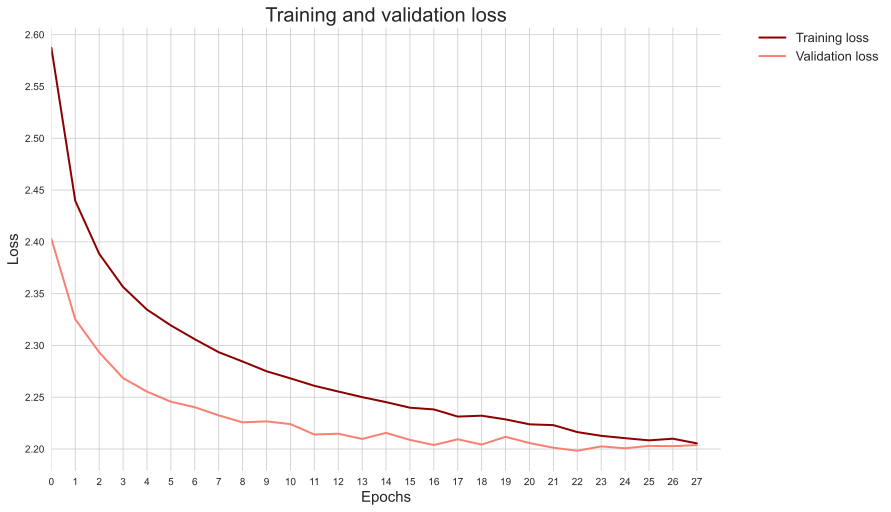

In [25]:
# Plot loss curves
plot_metric_curves(epochs, loss, val_loss, "darkred", "salmon", "Loss", 1)

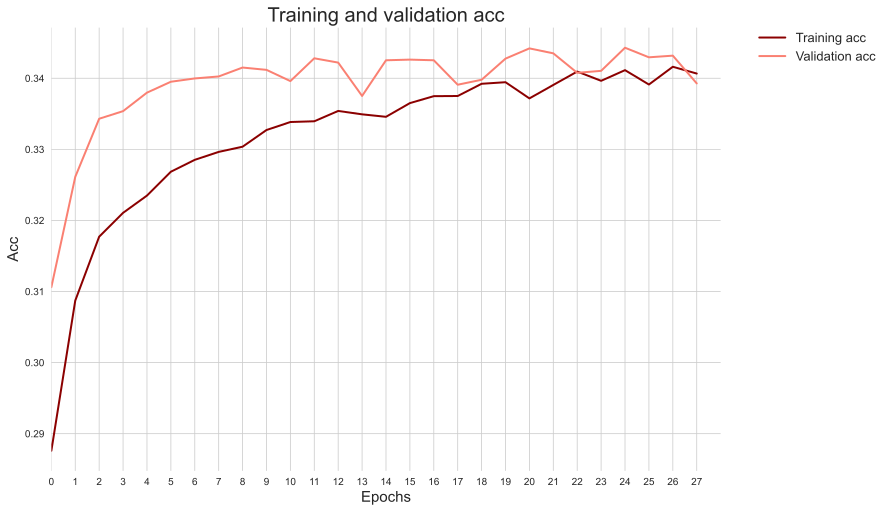

In [ ]:
# Plot loss curves
plot_metric_curves(epochs, acc, val_acc, "darkred", "salmon", "acc", 1)

### Predicciones

In [26]:
# Predecir las emociones en el conjunto de validación
y_pred_probs = model.predict(val_padded)

# Obtener las etiquetas originales de las emociones
y_val_labels = label_encoder.inverse_transform(y_val)
emotion_labels = label_encoder.classes_

673/673 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


In [27]:
emotion_to_emoji = {
    'admiration': '🤩',
    'amusement': '😄',
    'anger': '😡',
    'annoyance': '😑',
    'approval': '👍',
    'caring': '🥰',
    'confusion': '😕',
    'curiosity': '🤔',
    'desire': '😏',
    'disappointment': '😞',
    'disapproval': '👎',
    'disgust': '🤢',
    'embarrassment': '😳',
    'excitement': '😃',
    'fear': '😨',
    'gratitude': '🙏',
    'joy': '😀',
    'love': '❤️',
    'neutral': '😐',
    'optimism': '😊',
    'realization': '😲',
    'sadness': '😢',
    'surprise': '😮'
}

In [28]:
# Dataframe con texto, emoción real y top 3 de emociones predichas con sus probabilidades
df_results = pd.DataFrame(columns=['text', 'top1', 'top2', 'top3'])
df_results['text'] = X_val

# Obtener las etiquetas de las emociones predichas
top1_labels = [emotion_labels[i] for i in y_pred_probs.argsort()[:, -1]]
top2_labels = [emotion_labels[i] for i in y_pred_probs.argsort()[:, -2]]
top3_labels = [emotion_labels[i] for i in y_pred_probs.argsort()[:, -3]]

# Mapear las emociones a emojis
top1_labels = [emotion_to_emoji[label] for label in top1_labels]
top2_labels = [emotion_to_emoji[label] for label in top2_labels]
top3_labels = [emotion_to_emoji[label] for label in top3_labels]

# Obtener las probabilidades de las emociones predichas
top1_probs = y_pred_probs.max(axis=1) * 100  # Multiplicar por 100 para obtener el porcentaje
top2_probs = y_pred_probs[np.arange(len(y_val)), y_pred_probs.argsort()[:, -2]] * 100
top3_probs = y_pred_probs[np.arange(len(y_val)), y_pred_probs.argsort()[:, -3]] * 100

# Asignar valores al DataFrame
df_results['top1'] = [f'{label} {prob:.0f}%' for label, prob in zip(top1_labels, top1_probs)]
df_results['top2'] = [f'{label} {prob:.0f}%' for label, prob in zip(top2_labels, top2_probs)]
df_results['top3'] = [f'{label} {prob:.0f}%' for label, prob in zip(top3_labels, top3_probs)]

# Resetear el índice
df_results.reset_index(drop=True, inplace=True)

df_results.head()


,text,top1,top2,top3
0,Maybe could put context wa responding someone ...,😐 32%,😕 18%,🤔 11%
1,NAME like picking choosing life work fact work,😐 39%,👍 11%,🤩 9%
2,How people eat paper plate theyre bbq,🤔 42%,😐 27%,😕 14%
3,Thank voice reason people keep screaming Vatic...,🙏 95%,😐 2%,😑 1%
4,Gotta love trailing minute,❤️ 54%,😐 14%,😀 7%
